<a href="https://colab.research.google.com/github/karl-karlsson/notebooks/blob/main/concrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQLgPCGB5bTDJ4BfToaI0a3_AzMHXekHlLf_w&usqp=CAU)

# Modelling strength of concrete
The dataset for this project comes from the UCI ML repository ([source](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength)).

The aim of this project is to answer three hypothetical business questions:
* What's the optimum mixture of different ingridents (for example water and cement) to produce maximum strength?
* Given this mixture, for how long should we let concrete cure to produce maximum strength?
* Let's say we are a business that produces some concrete product and we have limited storage capacity, ie. we can't produce more products before products left to cure have been shipped. To maximize profit, how does the optimum number of days (to cure) change with the price-to-strength ratio for concrete?

The questions will be answered in the following process:

1. First we'll visuazlize the data using `ggplot2` to gain some understanding about distrubtions and relationships between variables
2. Then we'll model a linear regression and plot the marginal effects that each variable have on strength. This will give use an easy to understand baseline model and help us understand the data. 
3. In the third step, we'll train a stepwise linear regression where we'll allow nonlinearity in the form om polynomials and interactions between variables. We'll compare this model to the model in step 2. 
4. We'll also add a neural network 
5. And in the final step a random forest model
6. Based on the ouput from 2-5 we'll try to determine the optimum mixture 
6. Holding the other variables constant (at the optimum mixture) we'll see how days of curing affects strength
7. From the results in 6 we'll see how (optimum) days left to cure changes as the relationship between prices and strength of concrete changes
8. We'll summarize conclusions and possible business impact



In [164]:
# Keep track of total runtime
notebook_start = Sys.time()

In [165]:
# Turns "off" scientific output
options(scipen=999)

# Marings,reshape2 and corrplot packages are not installed by default in Google Colab
install.packages(c("margins","reshape2","corrplot",
"Metrics","caret","RSNNS",
"randomForest","DEoptim"))

# Load necessary packages
library(readr)
library(dplyr)
library(ggplot2)
library(margins)
library(reshape2)
library(corrplot)
library(Metrics)
library(caret)
library(MASS)
library(stringr)
library(RSNNS)
library(randomForest)
library(DEoptim)
library(forcats)


# Load data from GitHub
df = read_delim('https://raw.githubusercontent.com/karl-karlsson/data/main/Concrete_Data.csv',delim=";", show_col_types = F) %>%
mutate_all(as.numeric)

head(df)

print("# of rows")
nrow(df)

print("# of cols")
ncol(df)


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
540.0,0.0,0,162,2.5,1040.0,676.0,28,79.99
540.0,0.0,0,162,2.5,1055.0,676.0,28,61.89
332.5,142.5,0,228,0.0,932.0,594.0,270,40.27
332.5,142.5,0,228,0.0,932.0,594.0,365,41.05
198.6,132.4,0,192,0.0,978.4,825.5,360,44.30
266.0,114.0,0,228,0.0,932.0,670.0,90,47.03


[1] "# of rows"


[1] 1030

[1] "# of cols"


[1] 9

The dataset containts 1030 obeservations and 9 variables.

The variables:
* Cement (component 1)
* Blast Furnace Slag (component 2) 
* Fly Ash (component 3) 
* Water (component 4) 
* Superplasticizer (component 5)
* Coarse Aggregate (component 6) 
* Fine Aggregate (component 7) 
* Age

are all predictors/independent variables. All vars except age, which is measured in days, are in kg/m3.

The outcome variable is Strength which is measued in megapascal (MPa).

In [166]:
# The column names are a bit long so let's rename them
colnames(df) = c("Cement","Blast_furnace","Fly_ash","Water","Superplasticizer","Coarse_aggregate","Fine_aggreagate","Days","Strength")

# Visualize the data

No id variables; using all as measure variables



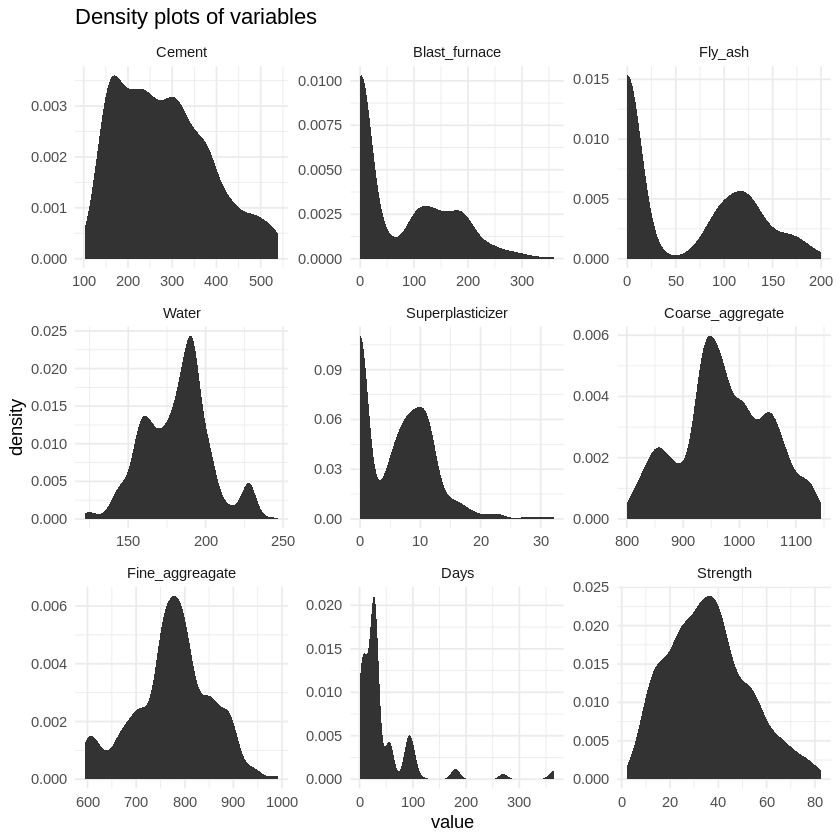

In [167]:
#Density plots
melt(df) %>%
ggplot(aes(x = value)) + 
stat_density() + 
facet_wrap(~variable, scales = "free")+
ggtitle("Density plots of variables")+
theme_minimal()

The density plots above show that:
* Concrete typically cure for < 75 days and that days > 100 are quite rare
* The distribution of some variables are bimodal, for example fly ash. This is because there are a lot of "0":s in the dataset meaning that fly ash wasn't added to the "recipe" at all but when it was it was typically used at concentrations at around 125 kg/m3.
* Strenght of concrete is somewhat normally distributed although a bit right-skewed

No id variables; using all as measure variables



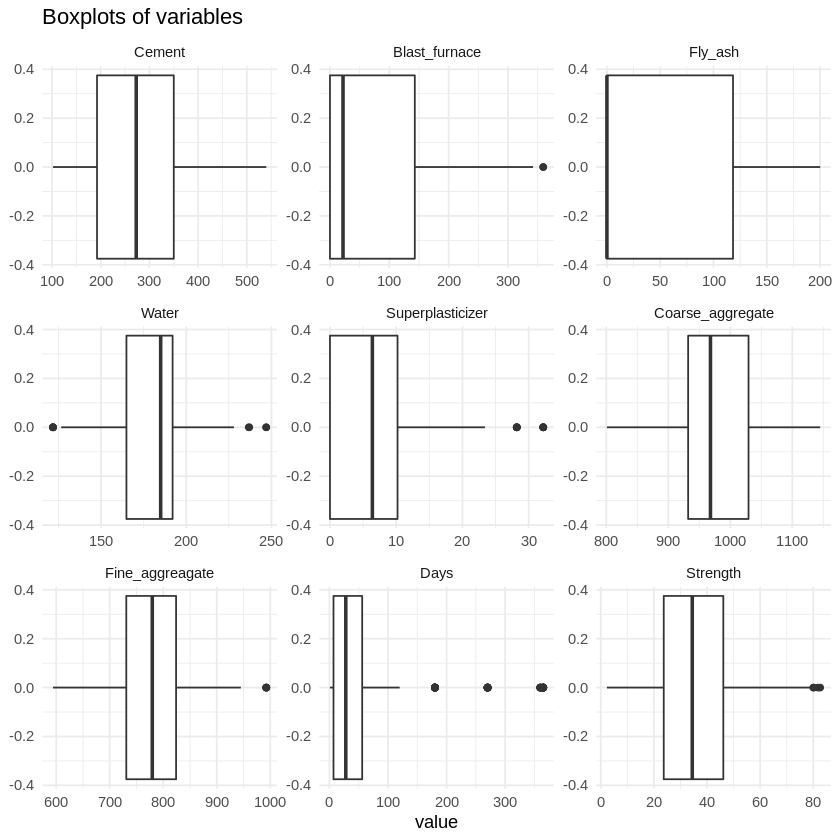

In [168]:
# Boxplots
melt(df) %>%
ggplot(aes(x = value)) + 
geom_boxplot() + 
facet_wrap(~variable, scales = "free")+
ggtitle("Boxplots of variables")+
theme_minimal()

The boxplots show that there are some outliers especially for the `Days` variable

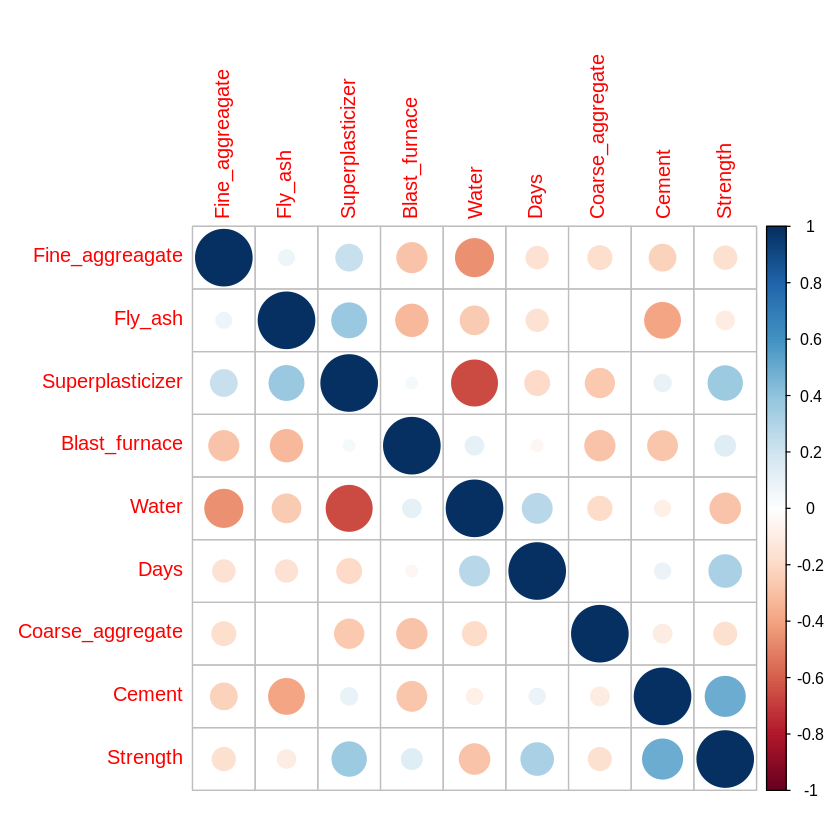

In [169]:
# Corrplot
cor(df) %>% corrplot(order="hclust")

The strength of concrete seem to be positively correlated to conceration of superplasticizers and cement and the number of days left to cure.

# Test and train split

In [170]:
# Test and train split
set.seed(220502)
trainindex = sort(sample(nrow(df), nrow(df)*.7))

train <-df[trainindex,]
test<-df[-trainindex,]

print(dim(train))
print(dim(test))

[1] 721   9
[1] 309   9


# Linear regression (OLS)

Time difference of 0.004114151 secs

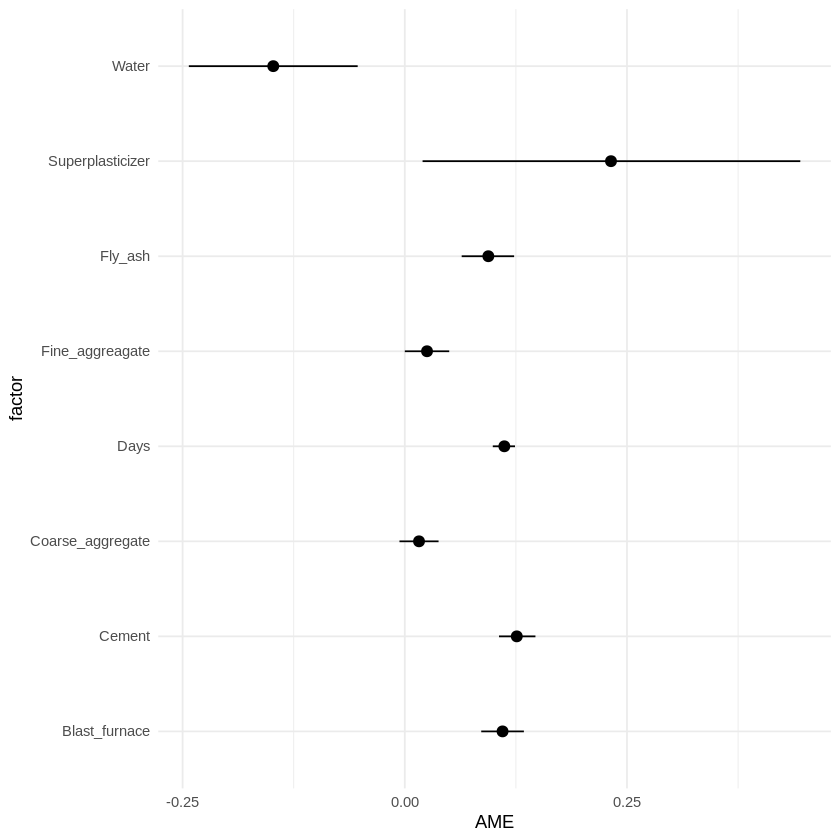

In [171]:
start_ols = Sys.time()



ols = lm(Strength ~ Cement + Blast_furnace + Fly_ash  + Water  + Superplasticizer  + Coarse_aggregate + Fine_aggreagate  + Days , data=train)

end_ols = Sys.time()

elapsed_ols = end_ols - start_ols
elapsed_ols

margins_ols = summary(margins(ols)) %>% 
as_tibble() %>% 
mutate_at(vars(-factor),as.numeric) %>%
mutate_at(vars(-factor), round, digits=3) %>%
mutate(model="ols")

margins_ols %>%
ggplot(aes(x=factor,y=AME, ymin=lower,ymax=upper))+
geom_pointrange()+
coord_flip()+
theme_minimal()


[ Text ]

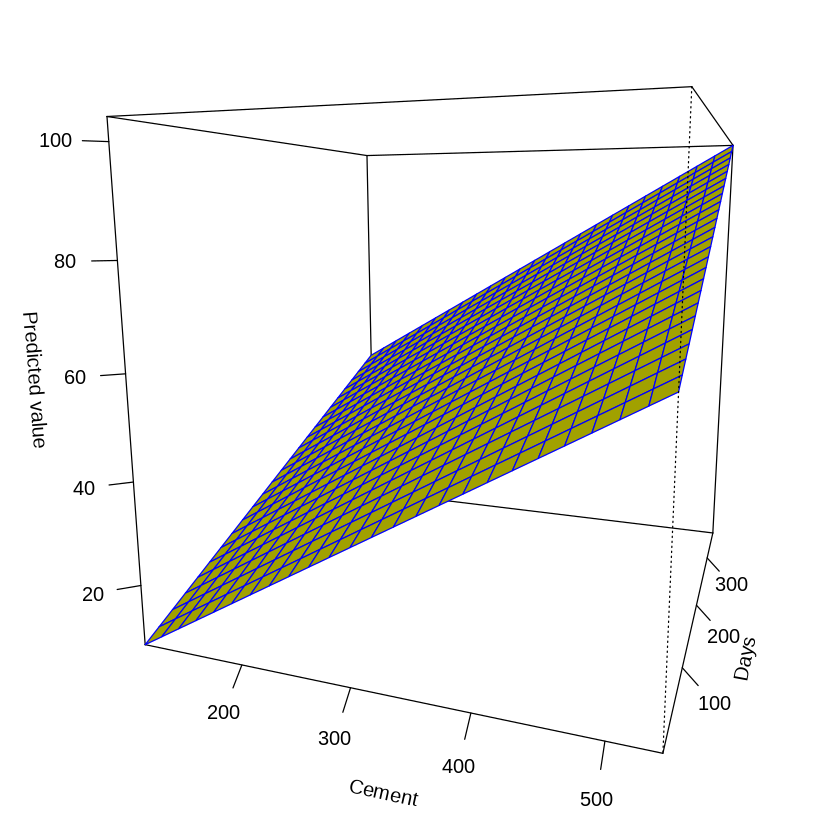

In [172]:
persp(ols,"Cement","Days",
      shade=0.4, col="yellow",border="blue", theta=c(20))


## Model performance

In [173]:
library(Metrics)

test$ols_predict = predict(ols, newdata=test)

# Mean absolute error
ols_mae = mae(test$Strength, test$ols_predict)
ols_mae

# Root mean squared error
ols_rmse = rmse(test$Strength, test$ols_predict)
ols_rmse

# MAPE
ols_mape = mape(test$Strength, test$ols_predict)

mod_eval = data.frame(ols_mae,ols_rmse,ols_mape,elapsed_ols)

colnames(mod_eval) = c("MAE","RMSE","MAPE","Time")
rownames(mod_eval) = c("OLS")
mod_eval 


[1] 8.422984

[1] 10.91387

,MAE,RMSE,MAPE,Time
,<dbl>,<dbl>,<dbl>,<drtn>
OLS,8.422984,10.91387,0.3257207,0.004114151 secs


# Stepwise regression

In [174]:
vars = colnames(df)[1:8]
formula = as.formula(paste0("Strength~.^2+",paste0("I(",vars,"^2)",collapse="+")))
formula


Strength ~ .^2 + I(Cement^2) + I(Blast_furnace^2) + I(Fly_ash^2) + 
    I(Water^2) + I(Superplasticizer^2) + I(Coarse_aggregate^2) + 
    I(Fine_aggreagate^2) + I(Days^2)

In [175]:
fitControl <- trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 5)

vars = colnames(df)[1:8]
model_spec = as.formula(paste0("Strength~.^2+",paste0("I(",vars,"^2)",collapse="+")))


start_stepwise = Sys.time()

stepwise <- caret::train(model_spec, data = train, 
                 method = "lmStepAIC", 
                 trControl = fitControl,
                 verbose = FALSE,
                 trace=FALSE)

end_stepwise = Sys.time()

elapsed_stepwise = end_stepwise - start_stepwise
elapsed_stepwise
    


Time difference of 8.186824 secs

In [176]:
stepwise$finalModel$call

lm(formula = .outcome ~ Cement + Blast_furnace + Fly_ash + Water + 
    Superplasticizer + Coarse_aggregate + Fine_aggreagate + Days + 
    `I(Cement^2)` + `I(Blast_furnace^2)` + `I(Water^2)` + `I(Superplasticizer^2)` + 
    `I(Coarse_aggregate^2)` + `I(Fine_aggreagate^2)` + `I(Days^2)` + 
    `Cement:Blast_furnace` + `Cement:Fly_ash` + `Cement:Water` + 
    `Cement:Superplasticizer` + `Cement:Coarse_aggregate` + `Cement:Fine_aggreagate` + 
    `Blast_furnace:Water` + `Blast_furnace:Superplasticizer` + 
    `Blast_furnace:Coarse_aggregate` + `Blast_furnace:Fine_aggreagate` + 
    `Blast_furnace:Days` + `Fly_ash:Water` + `Fly_ash:Superplasticizer` + 
    `Fly_ash:Coarse_aggregate` + `Fly_ash:Fine_aggreagate` + 
    `Fly_ash:Days` + `Water:Superplasticizer` + `Water:Coarse_aggregate` + 
    `Water:Fine_aggreagate` + `Water:Days` + `Superplasticizer:Coarse_aggregate` + 
    `Superplasticizer:Fine_aggreagate` + `Coarse_aggregate:Fine_aggreagate` + 
    `Coarse_aggregate:Days`, data = dat)

In [177]:
stepwise= lm(formula = Strength ~ Cement + Blast_furnace + Fly_ash + Water + 
    Superplasticizer + Coarse_aggregate + Fine_aggreagate + Days + 
    I(Cement^2) + I(Blast_furnace^2) + I(Water^2) + I(Superplasticizer^2) + 
    I(Coarse_aggregate^2) + I(Fine_aggreagate^2) + I(Days^2) + 
    Cement:Blast_furnace + Cement:Fly_ash + Cement:Water + 
    Cement:Superplasticizer + Cement:Coarse_aggregate + Cement:Fine_aggreagate + 
    Blast_furnace:Water + Blast_furnace:Superplasticizer + 
    Blast_furnace:Coarse_aggregate + Blast_furnace:Fine_aggreagate + 
    Blast_furnace:Days + Fly_ash:Water + Fly_ash:Superplasticizer + 
    Fly_ash:Coarse_aggregate + Fly_ash:Fine_aggreagate + 
    Fly_ash:Days + Water:Superplasticizer + Water:Coarse_aggregate + 
    Water:Fine_aggreagate + Water:Days + Superplasticizer:Coarse_aggregate + 
    Superplasticizer:Fine_aggreagate + Coarse_aggregate:Fine_aggreagate + 
    Coarse_aggregate:Days, data = train)


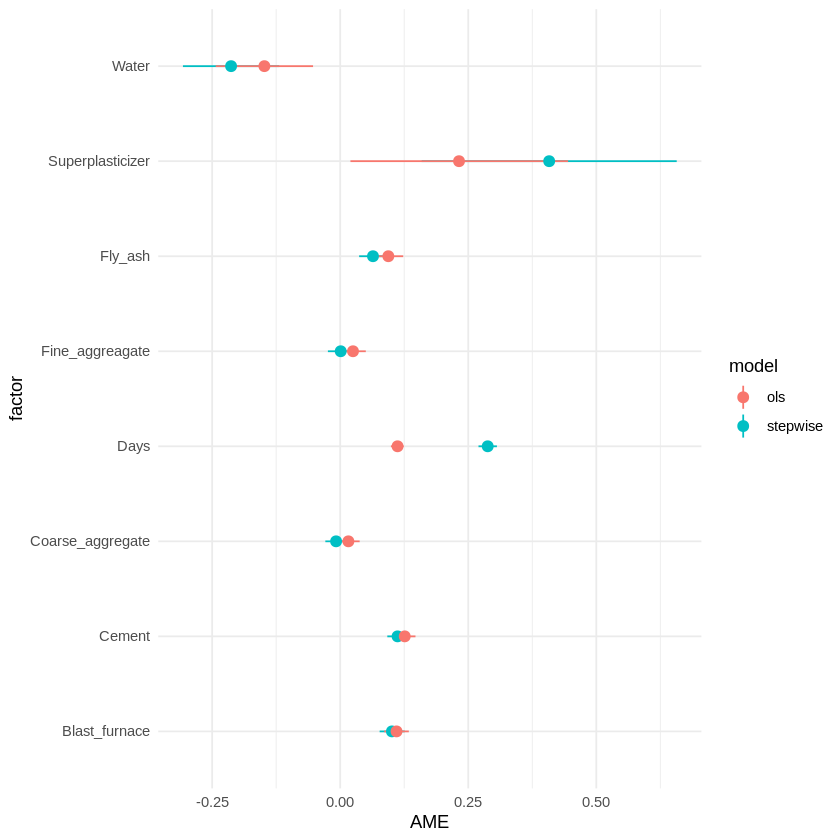

In [178]:
margins_stepwise = summary(margins(stepwise)) %>% 
as_tibble() %>% 
mutate_at(vars(-factor),as.numeric) %>%
mutate_at(vars(-factor), round, digits=3) %>%
mutate(model="stepwise")

margins_stepwise %>%
rbind(margins_ols) %>%
ggplot(aes(x=factor,y=AME, ymin=lower,ymax=upper,color=model))+
geom_pointrange()+
coord_flip()+
theme_minimal()

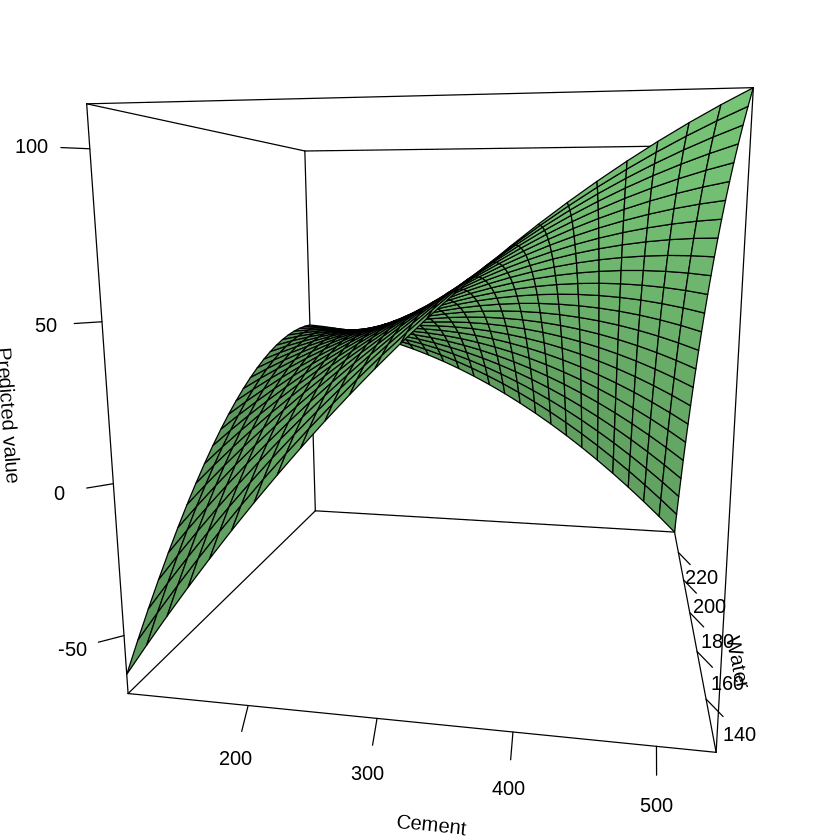

In [179]:
persp(stepwise,"Cement","Water",
      shade=0.4, col="lightgreen",border="black", theta=c(10))


## Model performance

In [180]:
test$stepwise_predict = predict(stepwise, newdata=test)

# Mean absolute error
stepwise_mae = mae(test$Strength, test$stepwise_predict)

# Root mean squared error
stepwise_rmse = rmse(test$Strength, test$stepwise_predict)

# Mape
stepwise_mape = mape(test$Strength, test$stepwise_predict)

mod_eval[2,1] =  mae(test$Strength, test$stepwise_predict)
mod_eval[2,2] = rmse(test$Strength, test$stepwise_predict)
mod_eval[2,3] = mape(test$Strength, test$stepwise_predict)
mod_eval[2,4] = elapsed_stepwise

rownames(mod_eval)[2] = "Stepwise"

mod_eval




,MAE,RMSE,MAPE,Time
,<dbl>,<dbl>,<dbl>,<drtn>
OLS,8.422984,10.91387,0.3257207,0.004114151 secs
Stepwise,6.320715,8.34439,0.2226845,8.186823845 secs


# Neural network

In [181]:
install.packages("RSNNS")
library(RSNNS)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [182]:
tune.grid.neuralnet <- expand.grid(
  size=seq(2,16,2)
)

start_nnet = Sys.time()



nnet_fit <- caret::train(Strength ~ ., data = train, 
                 method = "mlp",
                 preProc = c("center", "scale", "nzv"),
                 tuneGrid = tune.grid.neuralnet,
                 trControl = fitControl,
                 linout=T,
                 trace=F)

end_nnet = Sys.time()

elapsed_nnet = end_nnet - start_nnet
elapsed_nnet

    

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Time difference of 1.042318 mins

In [183]:
nnet_fit

Multi-Layer Perceptron 

721 samples
  8 predictor

Pre-processing: centered (8), scaled (8) 
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 577, 577, 577, 577, 576, 576, ... 
Resampling results across tuning parameters:

  size  RMSE      Rsquared   MAE      
   2    13.68364  0.4522941  11.106914
   4    12.57625  0.5511301  10.099888
   6    12.54829  0.5711698   9.920169
   8    12.28350  0.6040567   9.781421
  10    13.15308  0.5543142  10.476135
  12    13.99113  0.5453331  11.081832
  14    14.86011  0.4827141  11.782882
  16    19.02238  0.4001845  15.283406

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was size = 8.

## Model performance

In [184]:
test$nnet_predict = predict(nnet_fit, newdata=test)


mod_eval[3,1] =  mae(test$Strength, test$nnet_predict)
mod_eval[3,2] = rmse(test$Strength, test$nnet_predict)
mod_eval[3,3] = mape(test$Strength, test$nnet_predict)
mod_eval[3,4] = elapsed_nnet

rownames(mod_eval)[3] = "Neural network"

mod_eval




,MAE,RMSE,MAPE,Time
,<dbl>,<dbl>,<dbl>,<drtn>
OLS,8.422984,10.91387,0.3257207,0.004114151 secs
Stepwise,6.320715,8.34439,0.2226845,8.186823845 secs
Neural network,8.780098,11.38386,0.2869285,62.539057970 secs


# Random forest



In [185]:
tune.grid.rf <- expand.grid(
  mtry = c(2,3,4,5)
)

start_rf = Sys.time()
rf_fit <- caret::train(Strength ~ ., data = train, 
                 method = "rf",
                 tuneGrid = tune.grid.rf,
                 trControl = fitControl)
end_rf = Sys.time()

elapsed_rf = end_rf - start_rf
elapsed_rf

Time difference of 1.178027 mins

In [186]:
rf_fit

Random Forest 

721 samples
  8 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 577, 576, 577, 577, 577, 577, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
  2     5.979597  0.8969112  4.555418
  3     5.454805  0.9089404  4.083648
  4     5.313852  0.9099025  3.931527
  5     5.274289  0.9090907  3.860080

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 5.

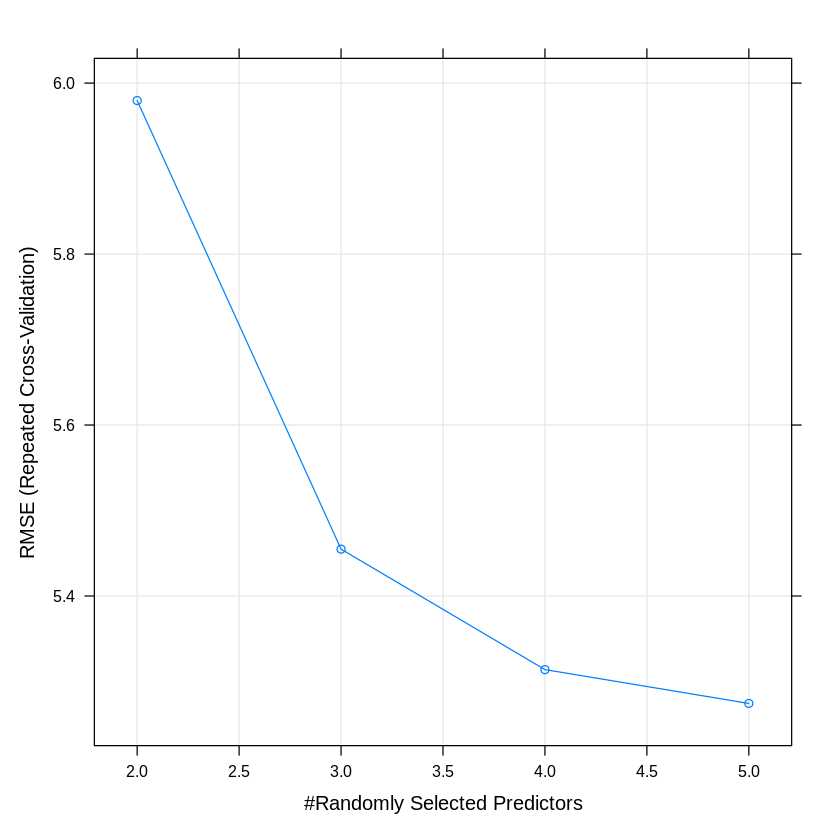

In [187]:
plot(rf_fit)

## Model performance

In [188]:
test$rf_predict = predict(rf_fit, newdata=test)


mod_eval[4,1] =  mae(test$Strength, test$rf_predict)
mod_eval[4,2] = rmse(test$Strength, test$rf_predict)
mod_eval[4,3] = mape(test$Strength, test$rf_predict)
mod_eval[4,4] = elapsed_rf

rownames(mod_eval)[4] = "Random forest"

mod_eval


,MAE,RMSE,MAPE,Time
,<dbl>,<dbl>,<dbl>,<drtn>
OLS,8.422984,10.913868,0.3257207,0.004114151 secs
Stepwise,6.320715,8.344390,0.2226845,8.186823845 secs
Neural network,8.780098,11.383861,0.2869285,62.539057970 secs
Random forest,3.457505,5.156584,0.1264416,70.681639433 secs


# Comparing model accurcay


Using model as id variables

Warning message:
“attributes are not identical across measure variables; they will be dropped”


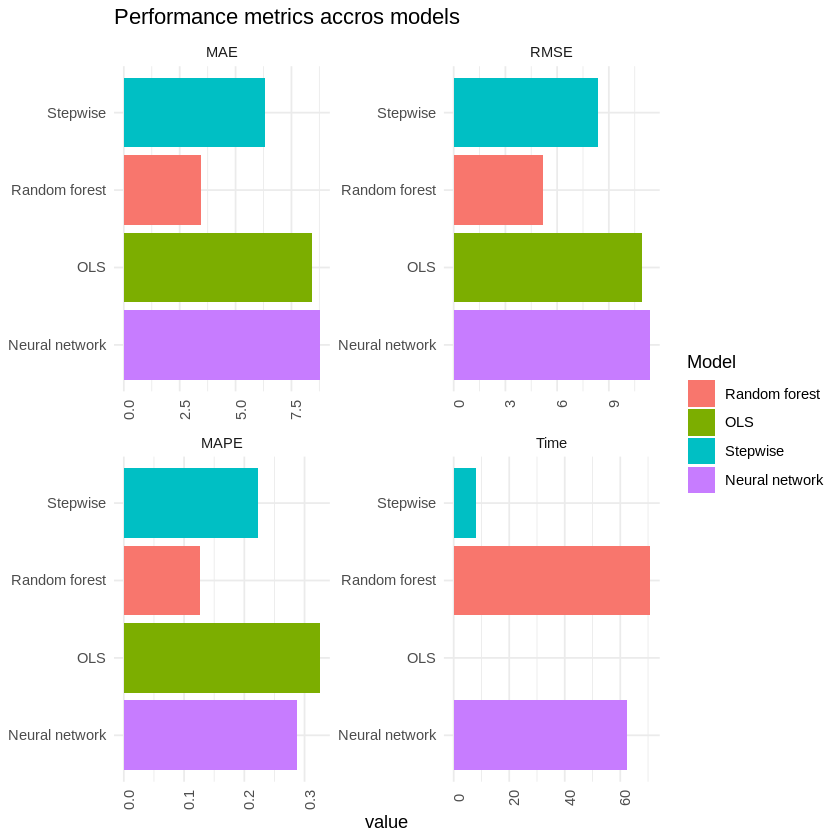

In [189]:
mod_eval %>%
mutate(model=rownames(.)) %>%
melt() %>%
ggplot(aes(x=model,y=value, fill=fct_reorder(model,value)))+
facet_wrap(~variable, scales="free")+
geom_col(position="dodge")+
coord_flip()+
theme_minimal()+
theme(axis.text.x = element_text(angle = 90))+
labs(fill="Model", title="Performance metrics accros models", x=NULL)



From the graph above it's clear that the random forest model has the best performance. Across all three accuracy metrics (MAE, RMSE and MAPE) it has about twice as good as the second best model (Stepwise).

For data of this size the time needed to train the model is not an issue but could be a factor to consider if size of data increases.

# Finding the optimum mixture

In [190]:
find_optimum = function(model,original_data) {
  labels = (attr(model$terms, "term.labels"))
  length = length(labels)

}

return_prediction = function(params = integer(8),model=rf_fit){
    newdata_df = as.data.frame(t(params))
    colnames(newdata_df) = colnames(rf_fit$trainingData)[2:9]
    prediction = predict(model, newdata=newdata_df)
    return(-prediction)

}

upper = integer(8)
lower = integer(8)
for(i in 1:8) {
  upper[i] = max(df[,i])*1.2
  lower[i] = min(df[,i])
}

optim = DEoptim(return_prediction, upper=upper,lower=lower, control = DEoptim.control(itermax=150, trace=FALSE))

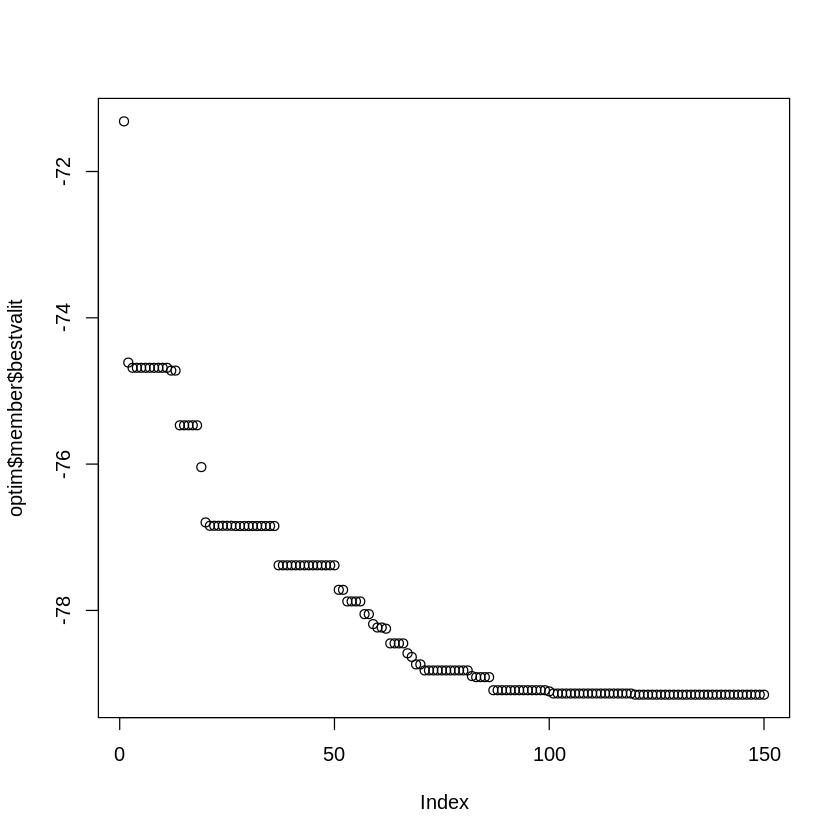

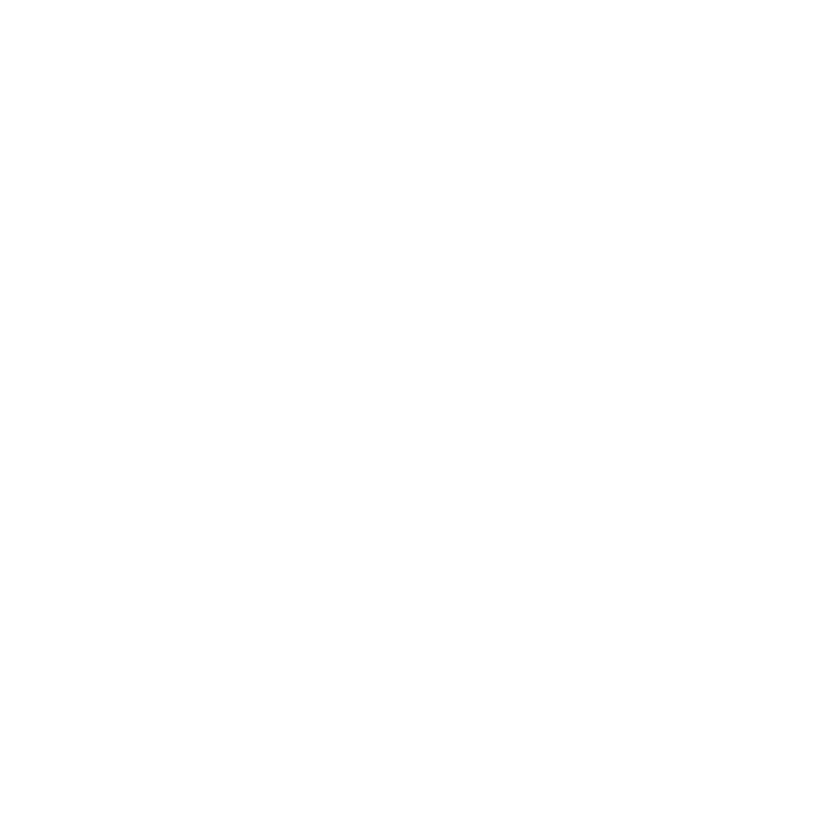

new plot


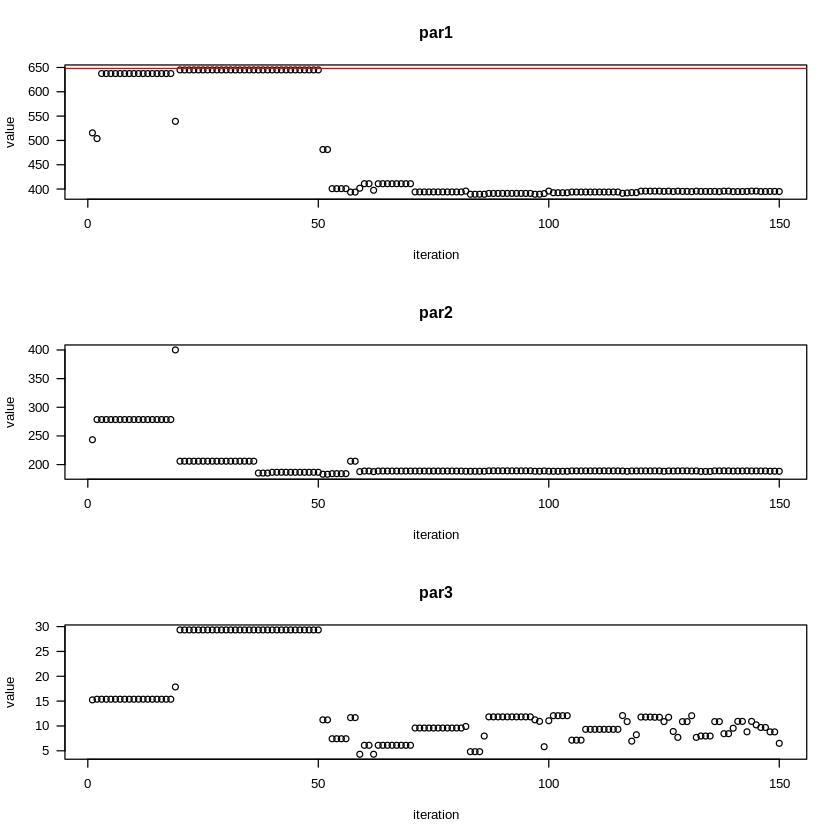

new plot


Cement,Blast_furnace,Fly_ash,Water,Superplasticizer,Coarse_aggregate,Fine_aggreagate,Days,Strength_predicted
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
396,189,10,146,21,945,756,86,79


Cement,Blast_furnace,Fly_ash,Water,Superplasticizer,Coarse_aggregate,Fine_aggreagate,Days,Strength
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
390,189,0,146,22,945,756,91,83
315,137,0,145,6,1130,745,28,82
324,283,0,184,10,943,660,56,80
540,0,0,162,2,1040,676,28,80
390,189,0,146,22,945,756,56,79


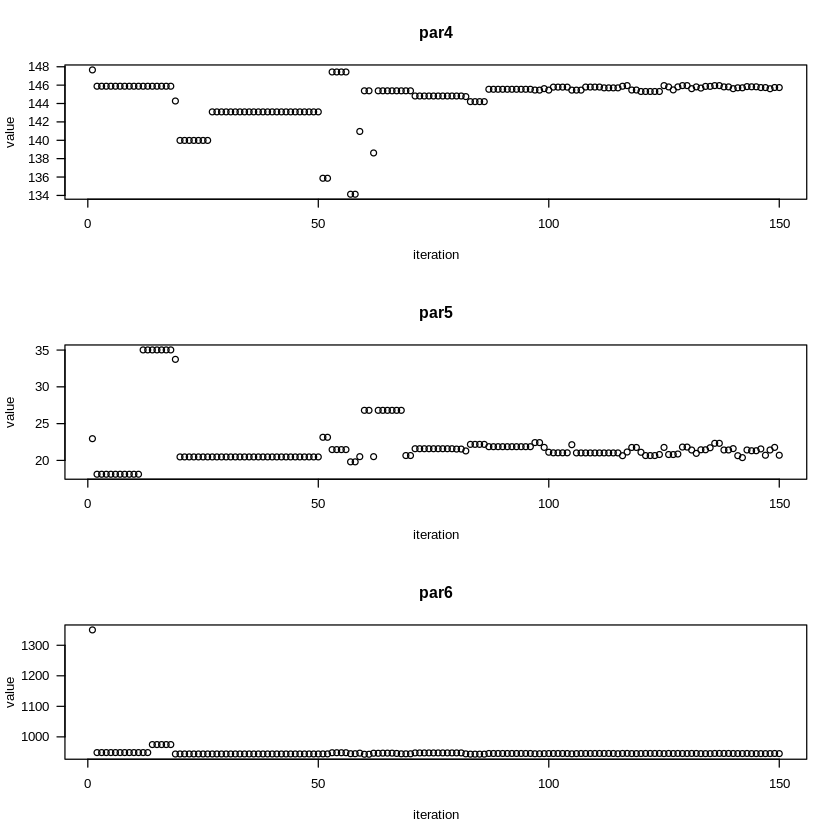

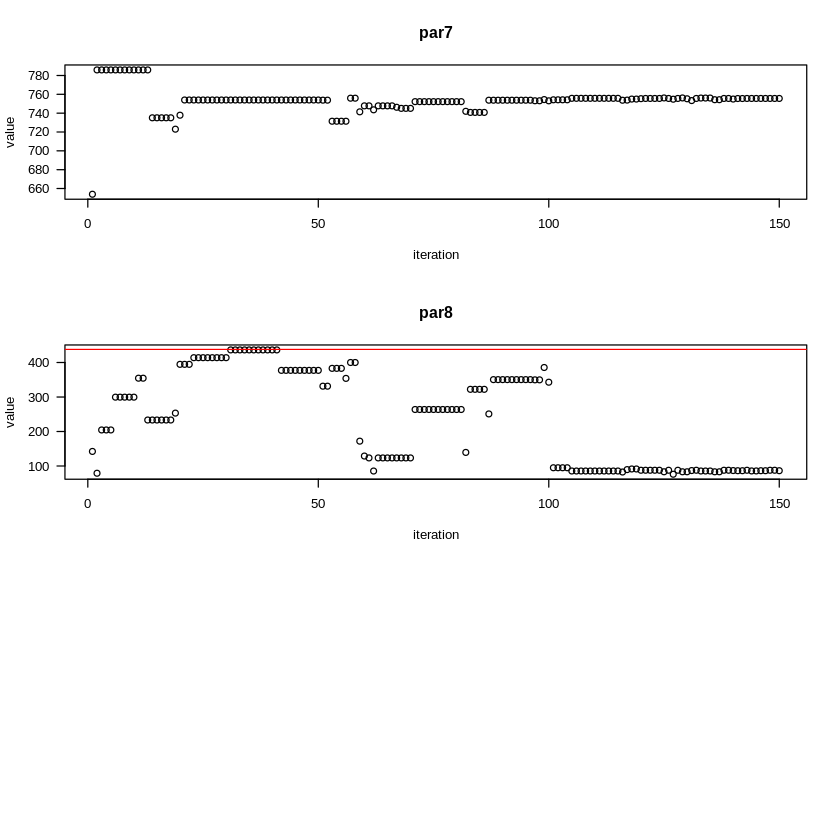

In [191]:
plot(optim$member$bestvalit)

plot(optim)

optimal_values = integer(8)
for(i in 1:length(optim$optim$bestmem)) {
  optimal_values[i] = optim$optim$bestmem[i]

}

optimal_values=as.data.frame(t(optimal_values))
colnames(optimal_values) = colnames(df)[1:8]
optimal_values$Strength_predicted = -optim$optim$bestval[length(optim$optim$bestval)]
optimal_values %>% round()

df %>% arrange(-Strength) %>% head(n=5) %>% round()



In [192]:
optim$optim$bestval

[1] -79.15124

# Nytt avsnitt

In [ ]:
# Function 1 / for a set of inputs, calc the strength
# return_prediction() 

# Function 2 / calc the cost of goods

# Function 3 / calc the salesprice of concrete based
return_salesprice = function()

# Final function (some wrapper function)


In [195]:
# End total runtime (for notebook)
notebook_end = Sys.time()

print("Total runtime for notebook:")
print(notebook_end - notebook_start)

[1] "Total runtime for notebook:"
Time difference of 6.208464 mins
